## Install Dependecies & Import Libraries

In [ ]:
!pip install ultralytics supervision

In [ ]:
import cv2
import numpy as np
import pandas as pd
import supervision as sv
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from pathlib import Path
import yaml
import shutil
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

In [ ]:
!nvidia-smi

Fri Nov 14 12:28:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!scp -r '/content/drive/MyDrive/Calory.v1i.yolov12.zip'

Mounted at /content/drive
usage: scp [-346ABCOpqRrsTv] [-c cipher] [-D sftp_server_path] [-F ssh_config]
           [-i identity_file] [-J destination] [-l limit]
           [-o ssh_option] [-P port] [-S program] source ... target


In [ ]:
!unzip /content/drive/MyDrive/Calory.v1i.yolov12.zip

Archive:  /content/drive/MyDrive/Calory.v1i.yolov12.zip
  inflating: README.dataset.txt      
  inflating: README.roboflow.txt     
  inflating: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/1374953_jpg.rf.8780beea257937e86e1f9b689fd32964.jpg  
 extracting: test/images/1380765_jpg.rf.f2ecf9bb6cd6989872aef51a81060bd5.jpg  
 extracting: test/images/1640730_jpg.rf.5ec16c880f17774c88bf9e593f824944.jpg  
 extracting: test/images/1652710_jpg.rf.b2c421a8847ae95ca183193fd24ec650.jpg  
 extracting: test/images/1675150_jpg.rf.51a989ad07c328afe9d7a2aceb1f3d9e.jpg  
 extracting: test/images/1699065_jpg.rf.0c0ba2878b2decbe522d64e18eeb0265.jpg  
 extracting: test/images/2158248_jpg.rf.a7f7051152a886f107f7596b3c184e64.jpg  
 extracting: test/images/2168761_jpg.rf.5a2d77b84be1d89597f7fac35e9614d4.jpg  
 extracting: test/images/2177889_jpg.rf.6ec6a297cedd0e6f0bcd6a11547f022d.jpg  
 extracting: test/images/2249127_jpg.rf.fae0a6cc8f5385e4cecbb6911af8f9ac.j

## Dataset Overview

In [ ]:
!ls /content/

data.yaml  README.dataset.txt	sample_data  train
drive	   README.roboflow.txt	test	     valid


In [ ]:
!cat /content/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 13
names: ['Ayam Goreng -260 kal per 100 gr-', 'Capcay -67 kal per 100gr-', 'Nasi -129 kal per 100gr-', 'Sayur bayam -36 kal per 100gr-', 'Sayur kangkung -98 kal per 100gr-', 'Sayur sop -22 kal per 100gr-', 'Tahu -80 kal per 100 gr-', 'Telur Dadar -93 kal per 100gr-', 'Telur Mata Sapi -110kal1butir-', 'Telur Rebus -78kal 1butir-', 'Tempe -225 kal per 100 gr-', 'Tumis buncis -65 kal per 100gr-', 'food-z7P4']

roboflow:
  workspace: ayu-asipq
  project: calory
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/ayu-asipq/calory/dataset/1

In [ ]:
train_size = len(os.listdir("/content/train/images"))
test_size = len(os.listdir("/content/test/images"))
val_size = len(os.listdir("/content/valid/images"))

print(f"Train Size: {train_size} images\n")
print(f"Test Size: {test_size} images\n")
print(f"Validation Size: {val_size} images")


Train Size: 721 images

Test Size: 106 images

Validation Size: 147 images


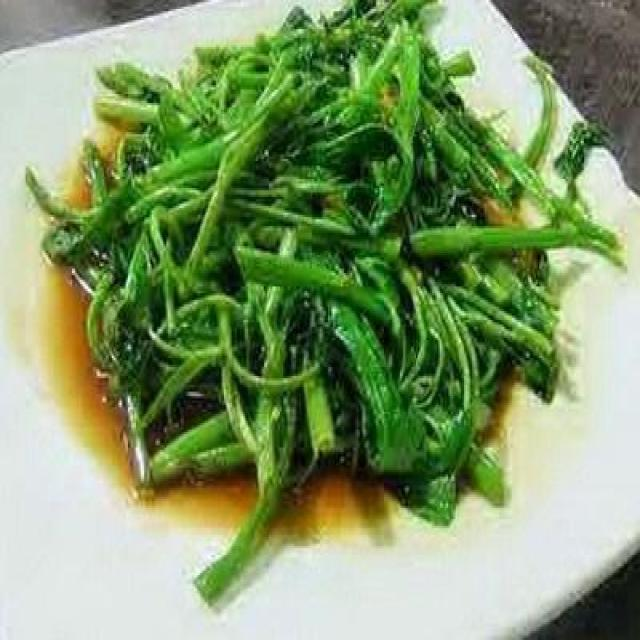

In [ ]:
# Contoh image dari train data
from IPython.display import Image

Image(filename="/content/train/images/02-resep_tumis_kangkung_-bumbu_dan_cara_membuat_atau_cara_memasak_jpg.rf.448a77c779b89dfc50e6418d04b76cdc.jpg", width=500)

In [ ]:
with open("/content/data.yaml", "r") as f:
  data_config = yaml.safe_load(f)

classes = data_config["names"]
print(f"Jumlah class: {len(classes)}\n")

Jumlah class: 13



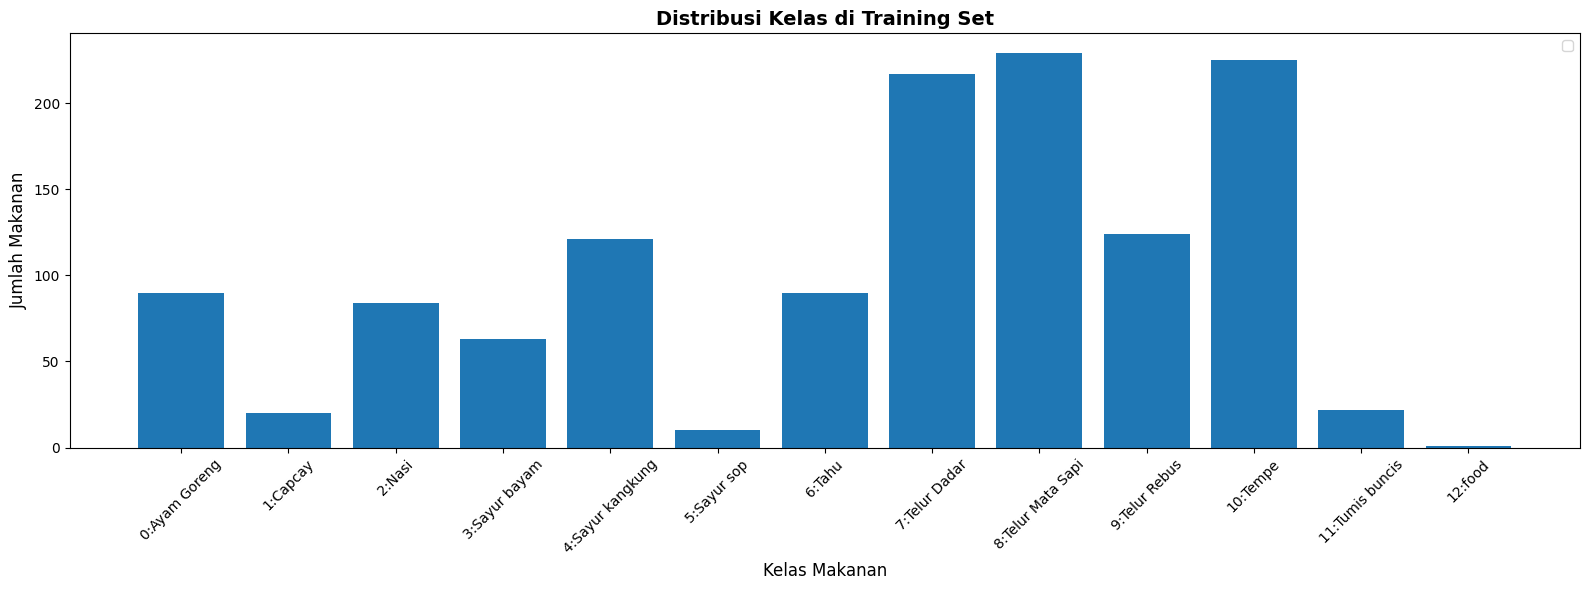

In [ ]:
train_data_labels = Path("/content/train/labels/")
class_counts = {i:0 for i in range(len(classes))}
bbox_area = []

def read_yolo_format(label_path):
  annotations = []
  try:
    with open(label_path, "r") as f:
      for line in f:
        parts = line.strip().split()
        if len(parts) >= 5:
          class_id = int(parts[0])
          x_center = float(parts[1])
          y_center = float(parts[2])
          width = float(parts[3])
          height = float(parts[4])
          annotations.append({
              'class_id': class_id,
              'bbox': [x_center, y_center, width, height]
          })
  except Exception as e:
    print(f"Error: {e}")
  return annotations


for label_file in train_data_labels.glob("*.txt"):
  annotations = read_yolo_format(label_file)
  for ann in annotations:
    class_counts[ann['class_id']] += 1
    bbox_area.append(ann['bbox'][2] * ann['bbox'][3])


plt.figure(figsize=(16, 6))
class_names_short = [f"{i}:{cls.split('-')[0].strip()}" for i, cls in enumerate(classes)]
counts = [class_counts[i] for i in range(len(classes))]
bars = plt.bar(range(len(classes)), counts)

plt.xticks(range(len(classes)), class_names_short, rotation=45)
plt.xlabel('Kelas Makanan', fontsize=12)
plt.ylabel('Jumlah Makanan', fontsize=12)
plt.title('Distribusi Kelas di Training Set', fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()


## Data Preprocessing

Check if there are any empty labels, missing labels, corrupt images, and invalid annotations

In [ ]:

def check_data_quality(images_dir, labels_dir):
    issues = {
        'corrupt_images': [],
        'missing_labels': [],
        'empty_labels': [],
        'invalid_annotations': []
    }

    images_dir = Path(images_dir)
    labels_dir = Path(labels_dir)

    image_files = list(images_dir.glob("*"))

    for img_path in image_files:
        # Check image corrupt
        try:
            img = cv2.imread(str(img_path))
            if img is None or img.size == 0:
                issues['corrupt_images'].append(img_path)
                continue
        except Exception as e:
            issues['corrupt_images'].append(img_path)
            continue

        # Check label
        label_path = labels_dir / (img_path.stem + ".txt")
        if not label_path.exists():
            issues['missing_labels'].append(img_path)
            continue

        # Check annotation validity
        annotations = read_yolo_format(label_path)
        if len(annotations) == 0:
            issues['empty_labels'].append(label_path)
        else:
            for ann in annotations:
                bbox = ann['bbox']
                if any(coord < 0 or coord > 1 for coord in bbox):
                    issues['invalid_annotations'].append(label_path)
                    break

    return issues


print("\nTraining set")
train_issues = check_data_quality("/content/train/images", "/content/train/labels")

print(f"Corrupt images: {len(train_issues['corrupt_images'])}")
print(f"Missing labels: {len(train_issues['missing_labels'])}")
print(f"Empty labels: {len(train_issues['empty_labels'])}")
print(f"Invalid annotations: {len(train_issues['invalid_annotations'])}")

print("\nValidation set")
val_issues = check_data_quality("/content/valid/images", "/content/valid/labels")

print(f"Corrupt images: {len(val_issues['corrupt_images'])}")
print(f"Missing labels: {len(val_issues['missing_labels'])}")
print(f"Empty labels: {len(val_issues['empty_labels'])}")
print(f"Invalid annotations: {len(val_issues['invalid_annotations'])}")

print("\nTesting set")
test_issues = check_data_quality("/content/test/images", "/content/test/labels")

print(f"Corrupt images: {len(test_issues['corrupt_images'])}")
print(f"Missing labels: {len(test_issues['missing_labels'])}")
print(f"Empty labels: {len(test_issues['empty_labels'])}")
print(f"Invalid annotations: {len(test_issues['invalid_annotations'])}")


Training set
Corrupt images: 0
Missing labels: 0
Empty labels: 5
Invalid annotations: 0

Validation set
Corrupt images: 0
Missing labels: 0
Empty labels: 1
Invalid annotations: 0

Testing set
Corrupt images: 0
Missing labels: 0
Empty labels: 0
Invalid annotations: 0


In [ ]:
# Handle issues
train_file_issues = train_issues['empty_labels']

for fname in train_file_issues:
    if fname.exists():
        fname.unlink()
        print(f'deleted: {fname}')

validation_file_issues = val_issues['empty_labels']

for fname in validation_file_issues:
    if fname.exists():
        fname.unlink()
        print(f'deleted: {fname}')

for lbl_path in train_file_issues + validation_file_issues:
    img_filename = lbl_path.name.replace('.txt', '.jpg')
    img_path = lbl_path.parent.parent / 'images' / img_filename

    if img_path.exists():
        img_path.unlink()
        print(f'deleted image: {img_path}')
    else:
        print(f"Image not found: {img_path}")

deleted: /content/train/labels/A270201XX_01403_jpg.rf.7f164a95c0b7e616301e30a1eadd7da6.txt
deleted: /content/train/labels/A270201XX_01394_jpg.rf.e7b58354a8f0f4768f336865460fa1e3.txt
deleted: /content/train/labels/A270201XX_01419_jpg.rf.9511df3819df8a63bb799991dea42f1a.txt
deleted: /content/train/labels/IMG-mi8lite-32-_jpeg.rf.679f494632547852bfd399d8df5466d7.txt
deleted: /content/train/labels/IMG-mi8lite-42-_jpeg.rf.8468396421585f91bf35e6859d30a3f2.txt
deleted: /content/valid/labels/A270201XX_01393_jpg.rf.5a8cd5dbd74c44bdafda0de590669ce1.txt
deleted image: /content/train/images/A270201XX_01403_jpg.rf.7f164a95c0b7e616301e30a1eadd7da6.jpg
deleted image: /content/train/images/A270201XX_01394_jpg.rf.e7b58354a8f0f4768f336865460fa1e3.jpg
deleted image: /content/train/images/A270201XX_01419_jpg.rf.9511df3819df8a63bb799991dea42f1a.jpg
deleted image: /content/train/images/IMG-mi8lite-32-_jpeg.rf.679f494632547852bfd399d8df5466d7.jpg
deleted image: /content/train/images/IMG-mi8lite-42-_jpeg.rf.84

In [ ]:
augmentation_pipeline = A.Compose([

    A.RandomBrightnessContrast(
        brightness_limit=0.25,
        contrast_limit=0.25,
        p=0.6
    ),

    A.HueSaturationValue(
        hue_shift_limit=15,
        sat_shift_limit=25,
        val_shift_limit=15,
        p=0.5
    ),

    A.RGBShift(
        r_shift_limit=20,
        g_shift_limit=20,
        b_shift_limit=20,
        p=0.4
    ),

    A.OneOf([
        A.GaussianBlur(blur_limit=(3,7), p=1.0),
        A.MedianBlur(blur_limit=5, p=1.0),
        A.MotionBlur(blur_limit=5, p=1.0),
    ], p=0.3),


    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),
        A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=1.0),
    ], p=0.3),


    A.OneOf([
        A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=1.0),
        A.UnsharpMask(blur_limit=(3,7), p=1.0),
    ], p=0.4),


    A.RandomShadow(
        shadow_roi=(0, 0.5, 1, 1),
        num_shadows_limit=(1, 2),
        p=0.25
    ),

    A.OneOf([
        A.ImageCompression(quality_lower=70, quality_upper=100, p=1.0),
        A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=cv2.INTER_LINEAR, p=1.0),
    ], p=0.25),


    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.2),

    A.Perspective(scale=(0.05, 0.1), p=0.3),

],
  bbox_params=A.BboxParams(
      format='yolo',
      label_fields=['class_labels'],
      min_visibility=0.3,
      min_area=0.001
  ))

In [ ]:
def augment_data(img_path, label_path, output_img_dir, output_label_dir, num_augs=2):

    img = cv2.imread(str(img_path))

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    annotations = read_yolo_format(label_path)
    bboxes = [ann['bbox'] for ann in annotations]
    class_labels = [ann['class_id'] for ann in annotations]

    aug_success = 0

    for aug_idx in range(num_augs):
        try:
            augmented = augmentation_pipeline(
                image=img_rgb,
                bboxes=bboxes,
                class_labels=class_labels
            )

            aug_img = augmented['image']
            aug_bboxes = augmented['bboxes']
            aug_class_labels = augmented['class_labels']

            img_ext = img_path.suffix.lower()
            aug_img_name = f"{img_path.stem}_aug{aug_idx}{img_ext}"
            aug_img_path = os.path.join(output_img_dir, aug_img_name)

            aug_img_bgr = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)

            if not os.path.exists(aug_img_path):
                print(f"Image file not found after save: {aug_img_path}")
                continue

            aug_label_name = f"{img_path.stem}_aug{aug_idx}.txt"
            aug_label_path = os.path.join(output_label_dir, aug_label_name)

            with open(aug_label_path, 'w') as f:
                for bbox, cls_label in zip(aug_bboxes, aug_class_labels):
                    f.write(f"{cls_label} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")

            aug_success += 1

        except Exception as e:
            print(f"Error augmenting {img_path.name}")
            continue

    return aug_success

In [ ]:
output_base = Path("/content/train_augmented")
output_images = output_base / "images"
output_labels = output_base / "labels"

output_images.mkdir(parents=True, exist_ok=True)
output_labels.mkdir(parents=True, exist_ok=True)

In [ ]:

# Copy Original Data

train_images_dir = Path("/content/train/images")
train_labels_dir = Path("/content/train/labels")

image_files = list(train_images_dir.glob("*"))

copied_imgs = 0
for img_path in tqdm(image_files, desc="Copying images"):
    try:
        dst = output_images / img_path.name
        shutil.copy2(str(img_path), str(dst))
        copied_imgs += 1
    except Exception as e:
        print(f"Error copying image {img_path.name}: {e}")
        failed_imgs += 1

print(f"Images copied: {copied_imgs}/{len(image_files)}")

label_files = list(train_labels_dir.glob("*.txt"))
print(f"\nFound {len(label_files)} labels in training set")

copied_labels = 0
for label_path in tqdm(label_files, desc="Copying labels"):
    try:
        dst = output_labels / label_path.name
        shutil.copy2(str(label_path), str(dst))
        copied_labels += 1
    except Exception as e:
        print(f"Error copying label {label_path.name}: {e}")

print(f"Labels copied: {copied_labels}/{len(label_files)}")

Copying images: 100%|██████████| 716/716 [00:00<00:00, 4139.94it/s]


Images copied: 716/716

Found 716 labels in training set


Copying labels: 100%|██████████| 716/716 [00:00<00:00, 6018.03it/s]

Labels copied: 716/716


In [ ]:
total_aug_created = 0

for img_path in tqdm(image_files, desc="Augmenting"):

    label_path = train_labels_dir / (img_path.stem + ".txt")

    img = cv2.imread(str(img_path))

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    annotations = read_yolo_format(label_path)

    bboxes = [ann['bbox'] for ann in annotations]
    class_labels = [ann['class_id'] for ann in annotations]

    # Generate 5 versions of augmentation
    for aug_idx in range(5):
        try:
            augmented = augmentation_pipeline(
                image=img_rgb,
                bboxes=bboxes,
                class_labels=class_labels
            )

            aug_img = augmented['image']
            aug_bboxes = augmented['bboxes']
            aug_class_labels = augmented['class_labels']

            if len(aug_bboxes) == 0:
                continue

            img_ext = img_path.suffix
            aug_img_name = f"{img_path.stem}_aug{aug_idx}{img_ext}"
            aug_img_path = output_images / aug_img_name
            aug_img_bgr = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)


            aug_label_name = f"{img_path.stem}_aug{aug_idx}.txt"
            aug_label_path = output_labels / aug_label_name

            with open(aug_label_path, 'w') as f:
                for bbox, cls_label in zip(aug_bboxes, aug_class_labels):
                    f.write(f"{cls_label} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")

            cv2.imwrite(str(aug_img_path), aug_img_bgr)

            total_aug_created += 1

        except Exception as e:
            continue

final_train_size = len(list(Path("/content/train_augmented/images").glob("*")))

print(f"\nOriginal images: {train_size}\n")
print(f"Augmented images created: {total_aug_created}\n")
print(f"Total training images: {final_train_size}\n")



Augmenting: 100%|██████████| 716/716 [02:00<00:00,  5.94it/s]


Original images: 721

Augmented images created: 3578

Total training images: 4294



In [ ]:
clean_classes = [cls.split(' -')[0].replace(' ', '') for cls in classes]

data_yaml_content = f"""
train: /content/train_augmented/images
val: /content/valid/images
test: /content/test/images

nc: {len(classes)}
names: {clean_classes}


# Train: {final_train_size} images (original: {train_size}, augmented: {total_aug_created})
# Validation: {val_size} images
# Test: {test_size} images
"""

with open('/content/data_augmented.yaml', 'w') as f:
    f.write(data_yaml_content)

print("\nConfiguration file saved")


Configuration file saved


## Download Model Object Detection & Train Model

In [ ]:
!wget https://github.com/ultralytics/assets/releases/download/v8.1.0/yolov8m.pt

--2025-11-14 12:31:32--  https://github.com/ultralytics/assets/releases/download/v8.1.0/yolov8m.pt
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/521807533/b9e3f13e-8096-4982-b847-23178025b7fe?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-11-14T13%3A11%3A27Z&rscd=attachment%3B+filename%3Dyolov8m.pt&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-11-14T12%3A10%3A39Z&ske=2025-11-14T13%3A11%3A27Z&sks=b&skv=2018-11-09&sig=nbn1A0N774XEyHAeBkmjjUf2Xxq4%2FDnUmEpkDa77GtQ%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2MzEyNTI5MiwibmJmIjoxNzYzMTIzNDkyLCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi5ibG9iLmNvcmU

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8m.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [29]:
results = model.train(
    data='/content/data_augmented.yaml',
    epochs=50,
    batch=16,
    imgsz=640,
    lr0=0.008,
    weight_decay=0.0003,
    mosaic=1.0,
    mixup=0.15,
    copy_paste=0.3,
    close_mosaic=15,
    optimizer='AdamW',
    workers=4,
    device=0,
    patience=15,
    save_period=10,
    val=True,
    verbose=True,
    exist_ok=True,
    box=7.5,
    cls=0.5,
    dfl=1.5,
)

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=15, cls=0.5, compile=False, conf=None, copy_paste=0.3, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data_augmented.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.008, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.15, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=15, perspective=0.0, plots=True, pose=12.

In [30]:
src = '/content/runs/detect/train/weights/best.pt'
dst = '/content/final_model.pt'
shutil.copy(src, dst)
print('Size:', os.path.getsize(dst), 'bytes')

Size: 52043538 bytes


In [31]:
from google.colab import files
files.download(dst)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Evaluation

In [32]:
model = YOLO('/content/final_model.pt')
data_yaml = '/content/data_augmented.yaml'

In [33]:
results = model.val(data=data_yaml, split='test')
print(results)

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,847,287 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 14.0±3.4 MB/s, size: 40.1 KB)
val: Scanning /content/test/labels... 106 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 106/106 406.8it/s 0.3s
val: New cache created: /content/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 1.5it/s 4.7s
                   all        106        126      0.821      0.773      0.806      0.583
                Capcay          6          6          1      0.922      0.995      0.831
         Sayurkangkung         10         10      0.817          1      0.995      0.695
                  Tahu          2          3      0.858      0.667      0.699      0.489
            TelurDadar         50         52      0.907      0.937      0.979      0.754
         TelurMat

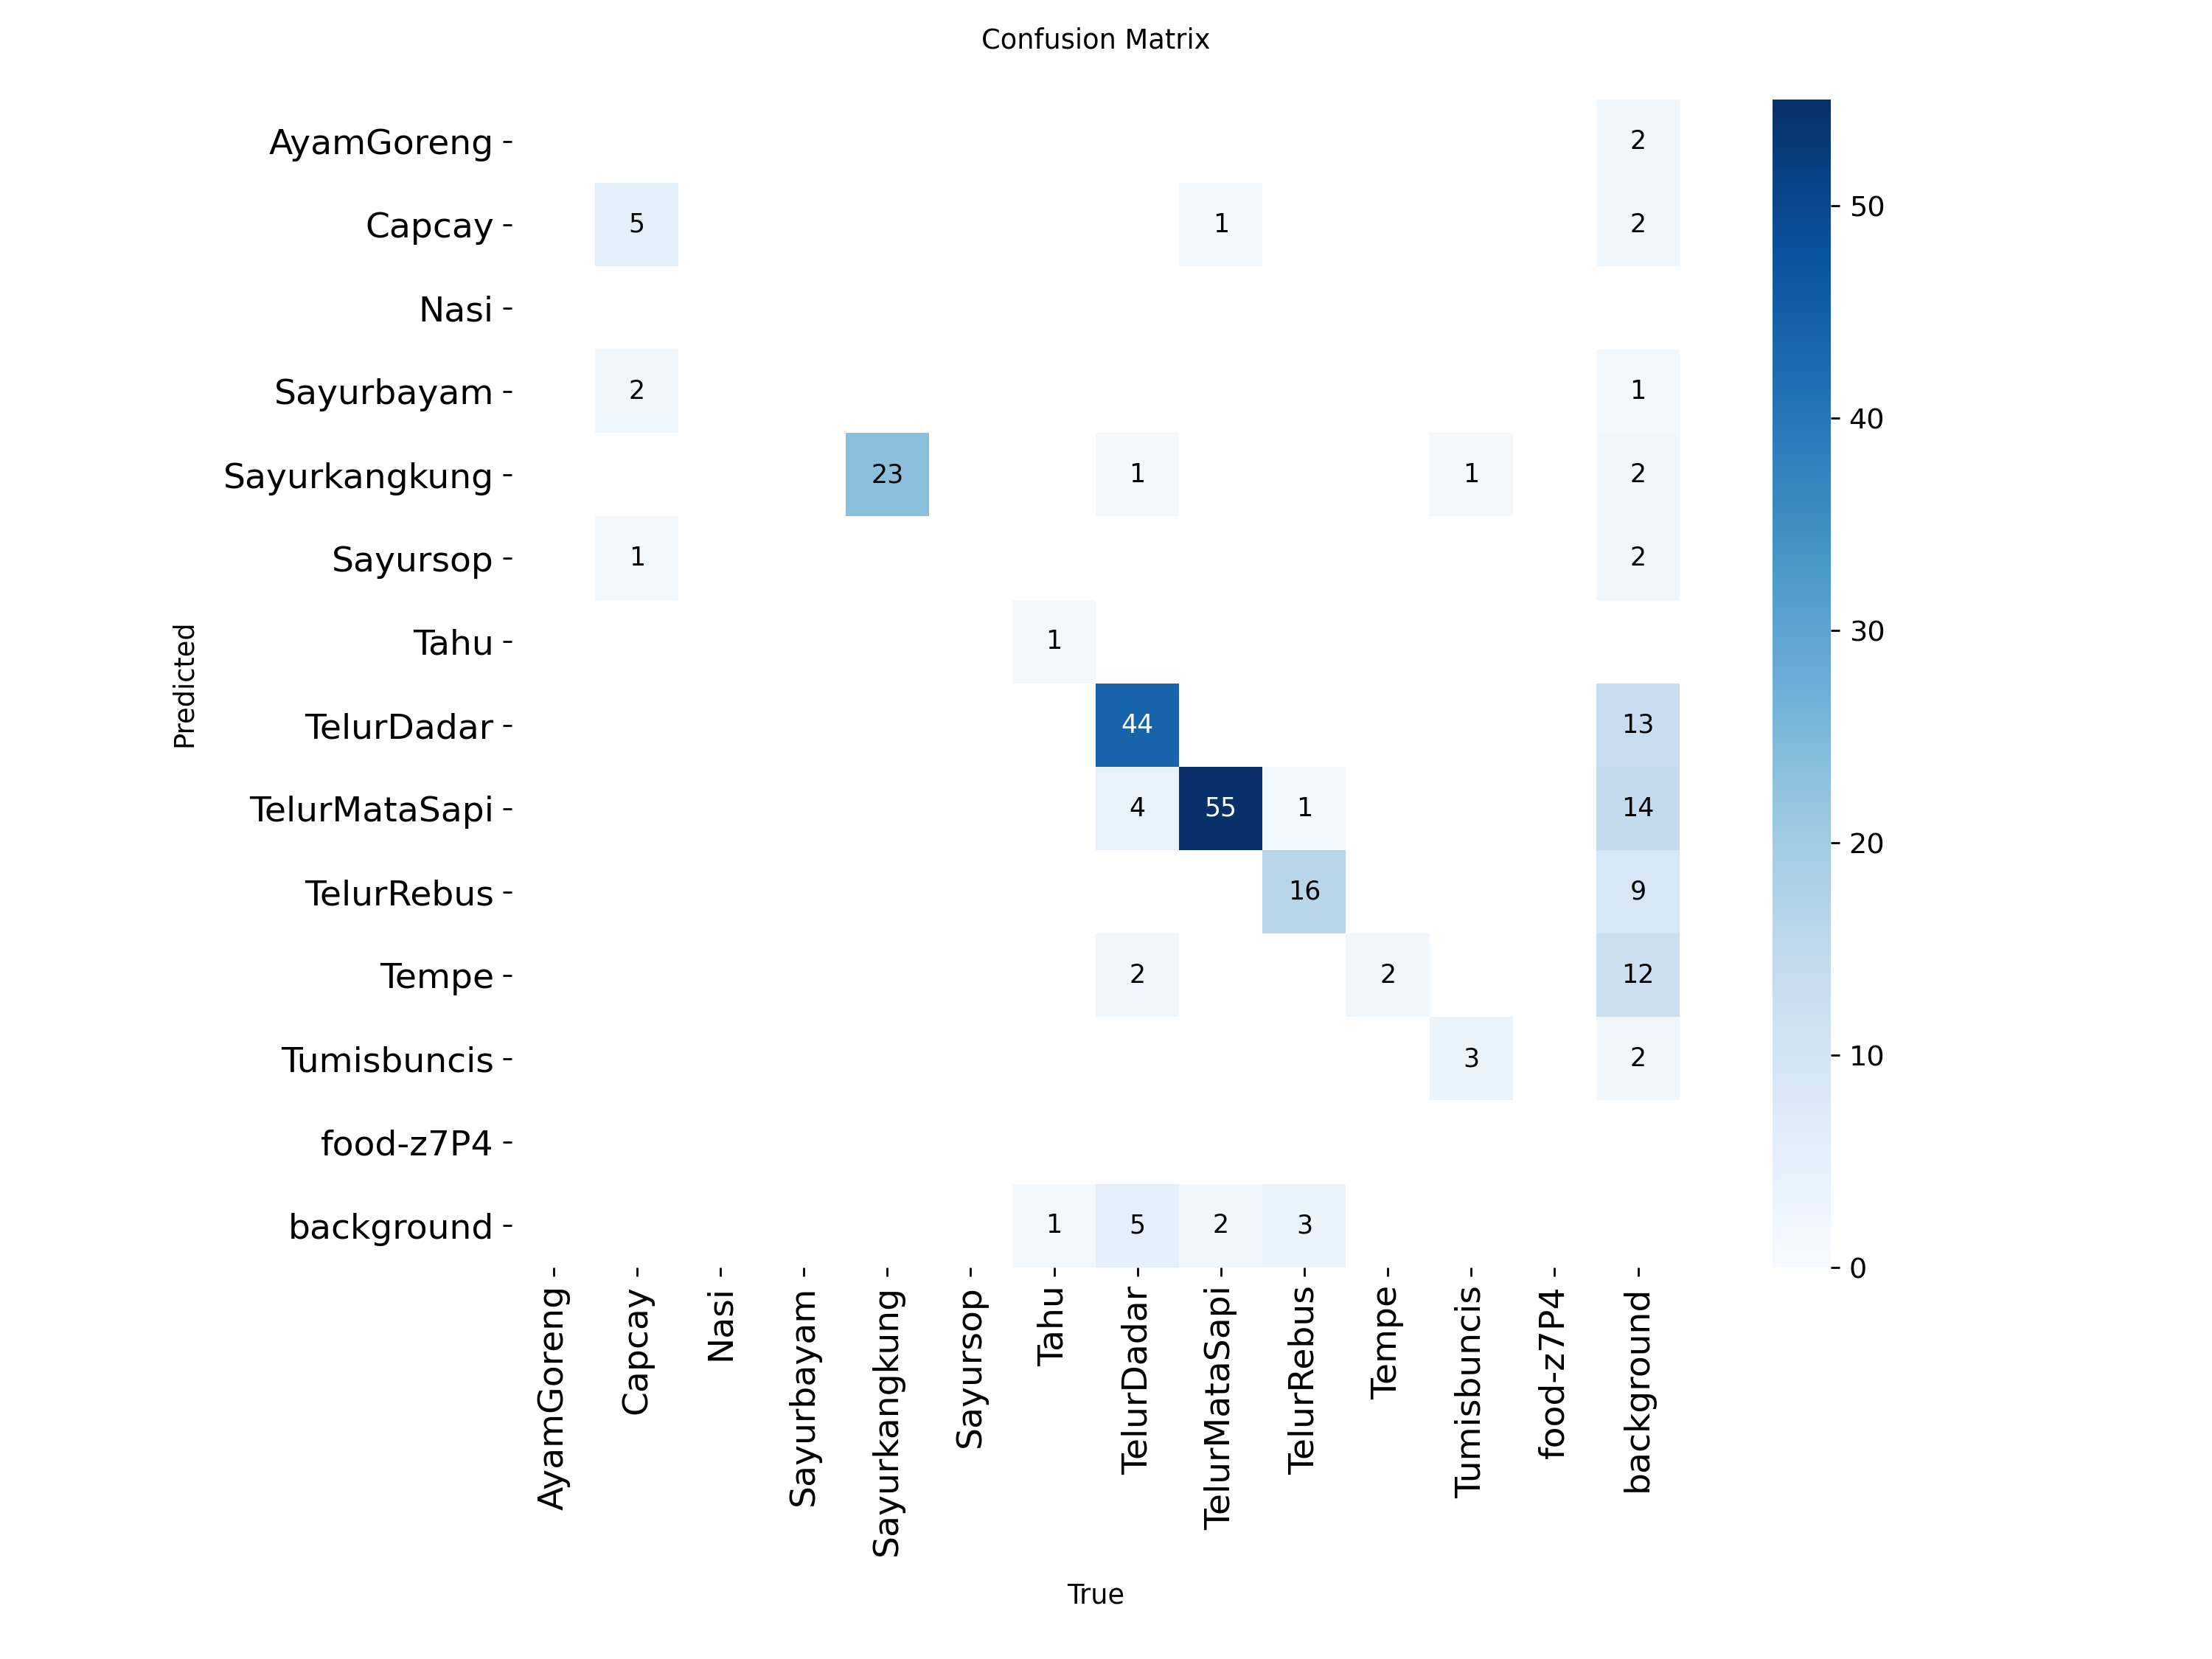

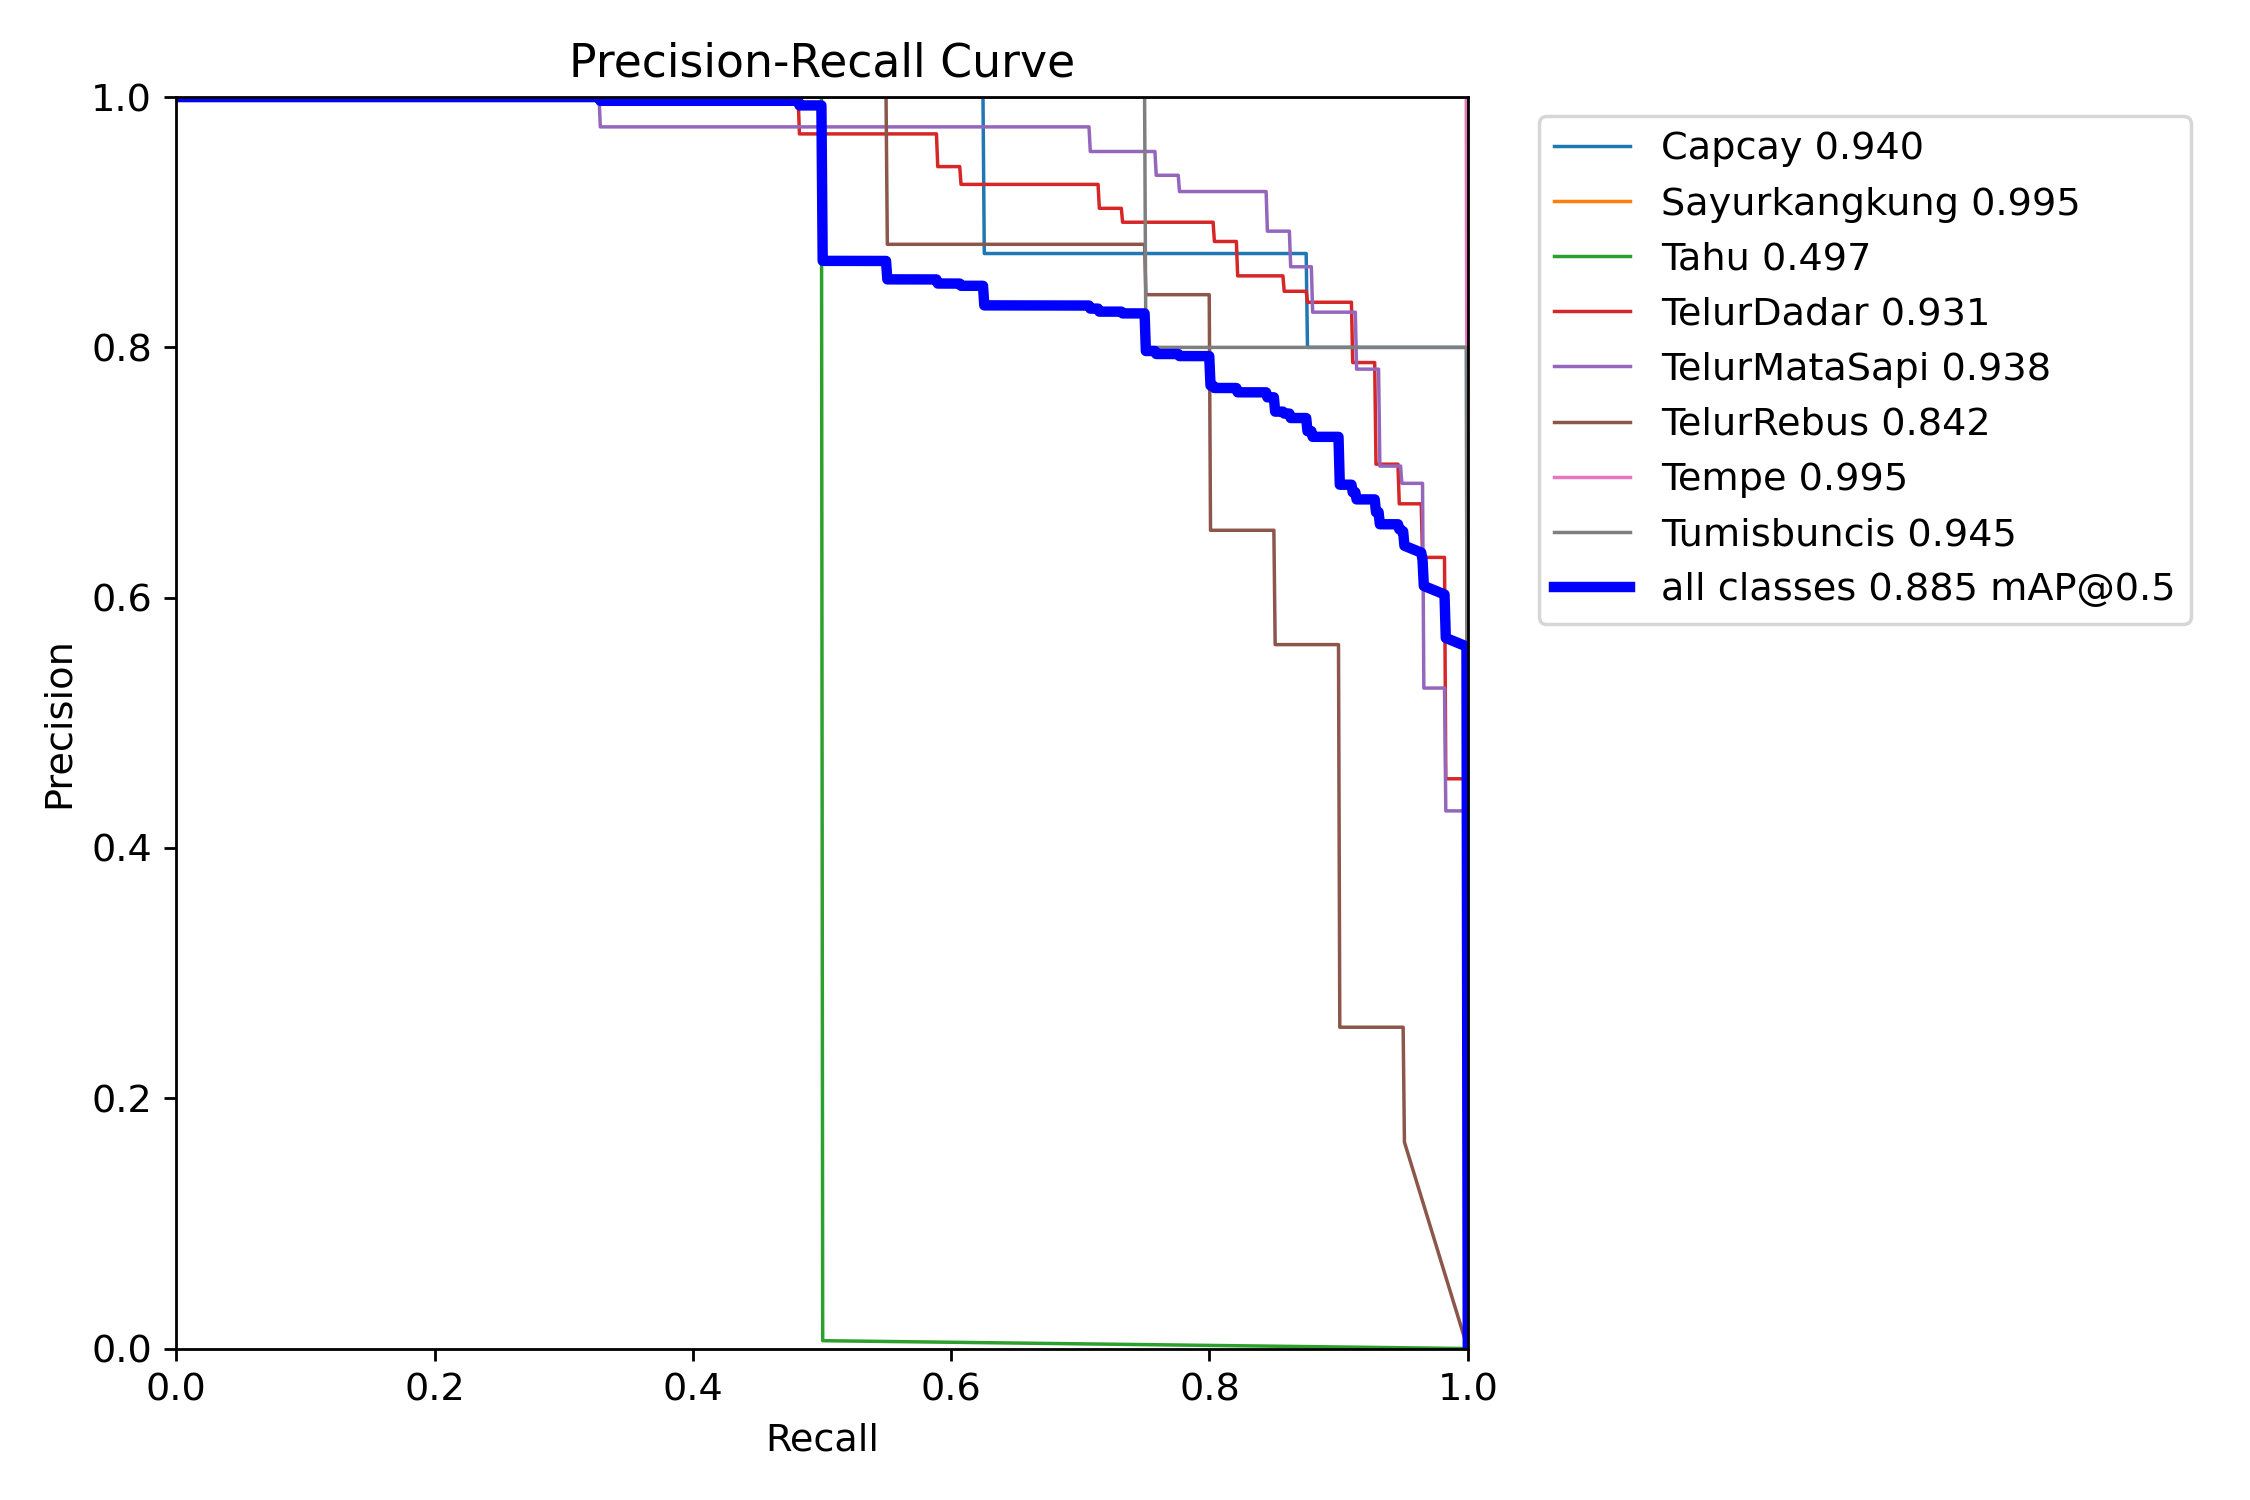

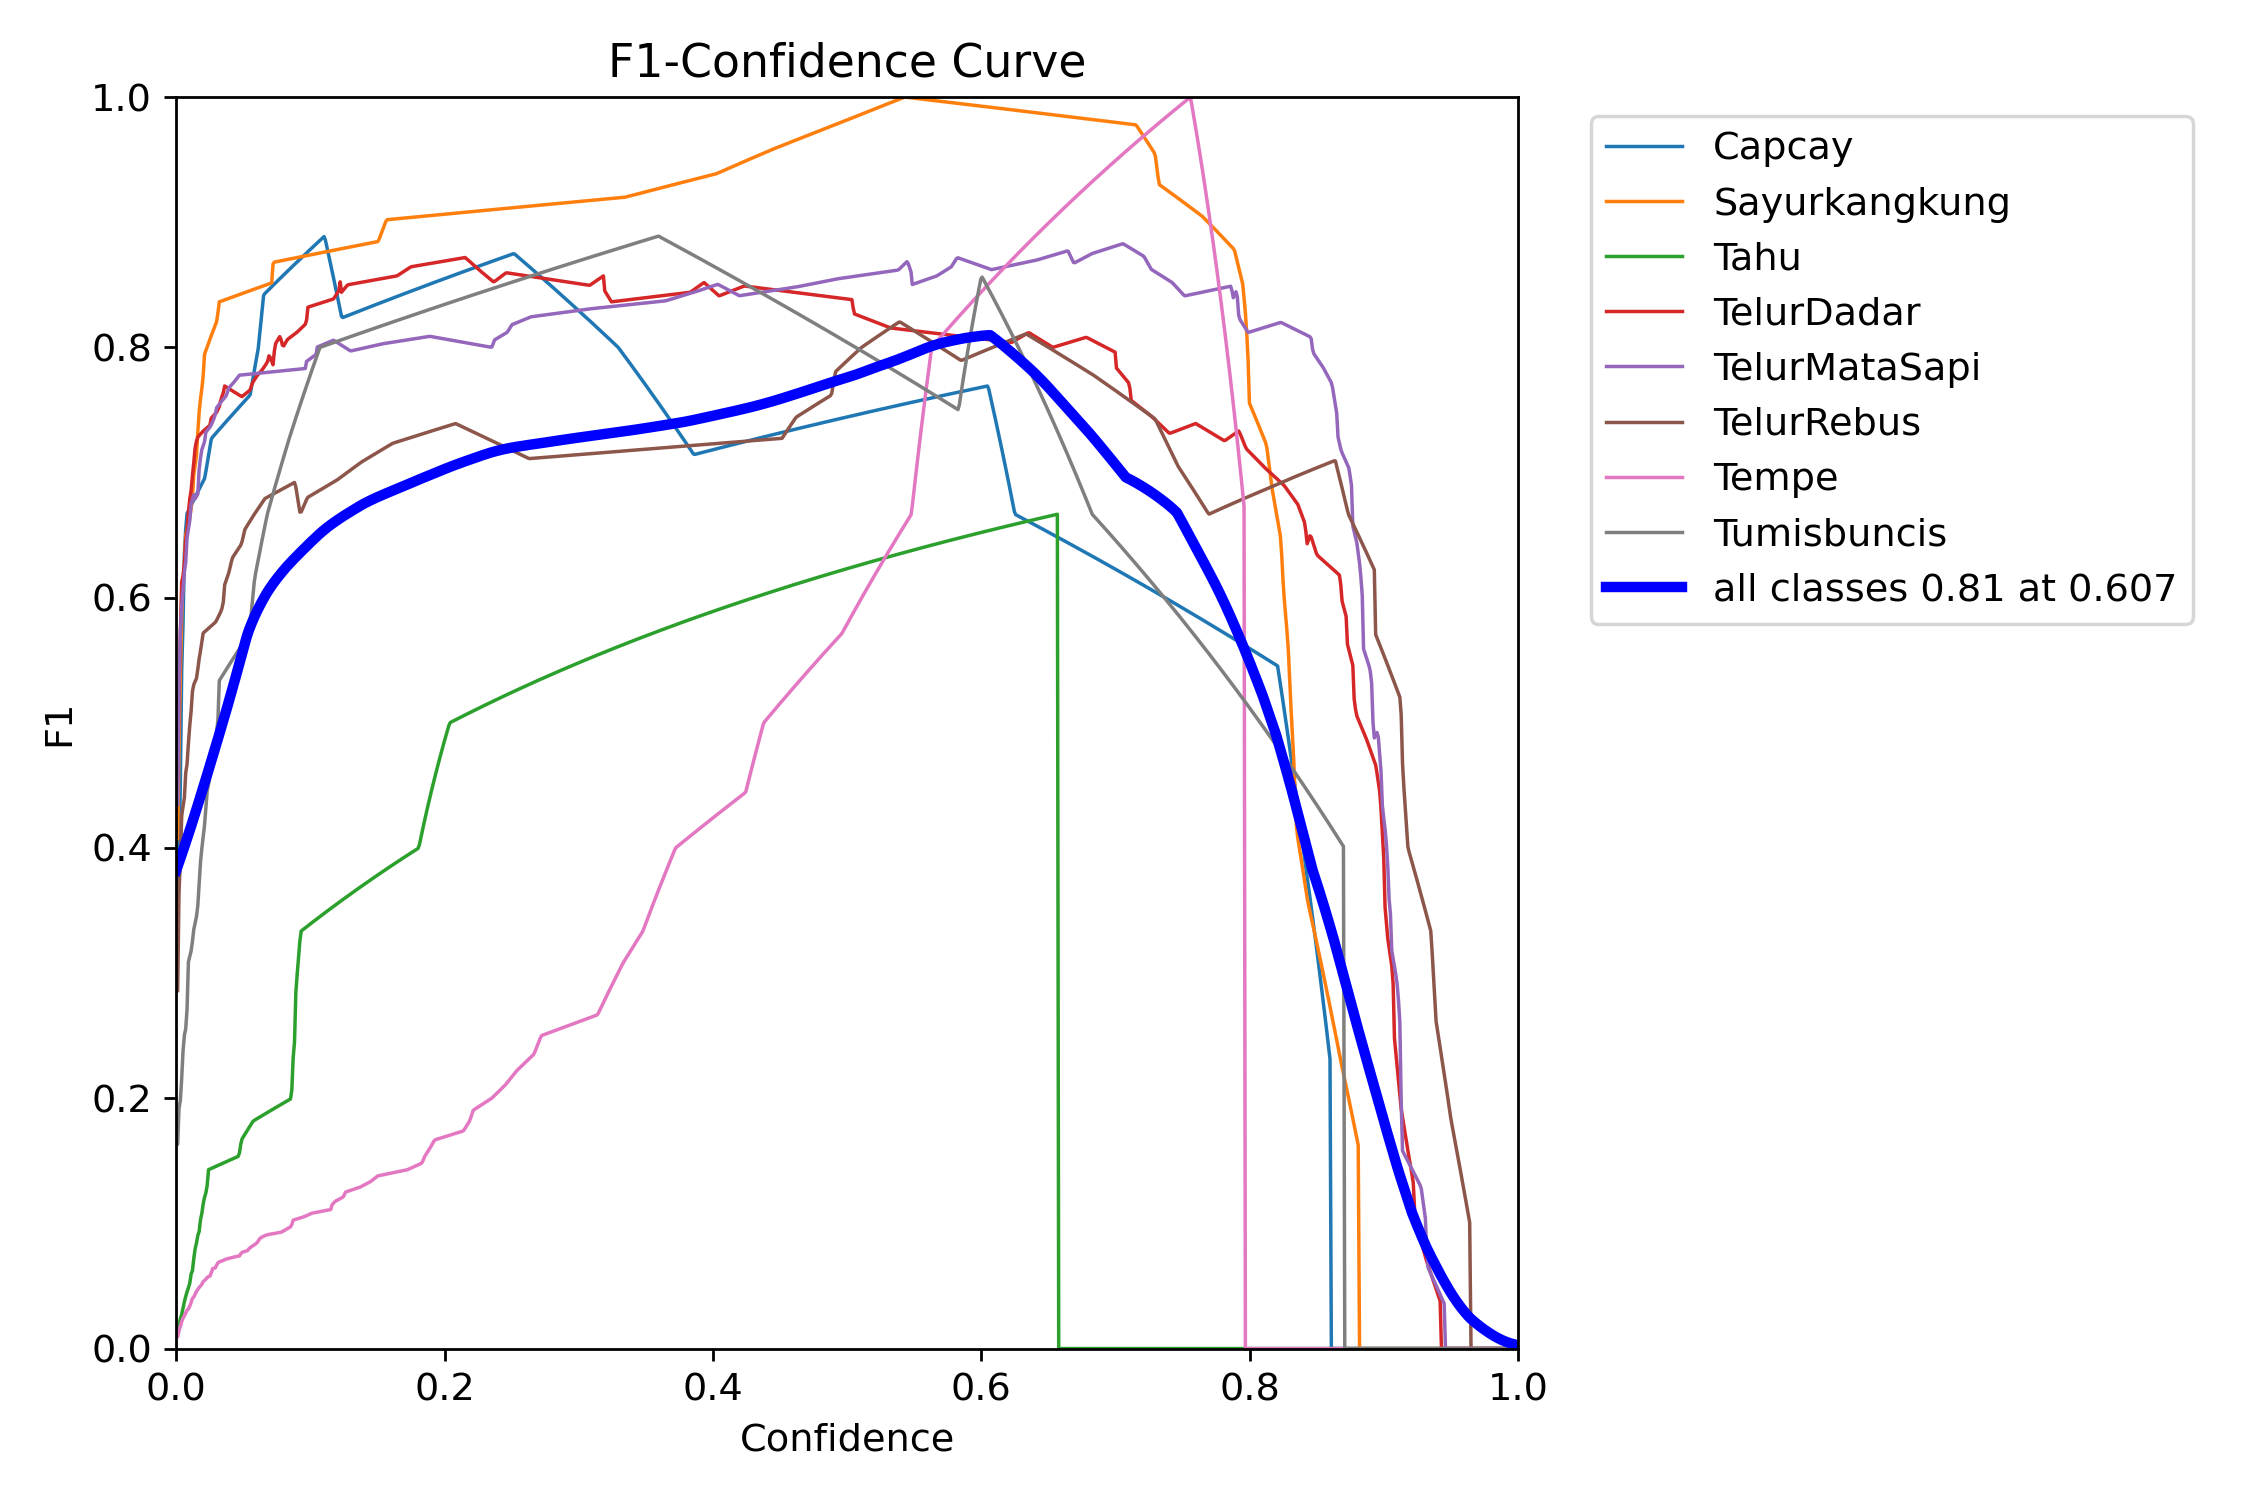

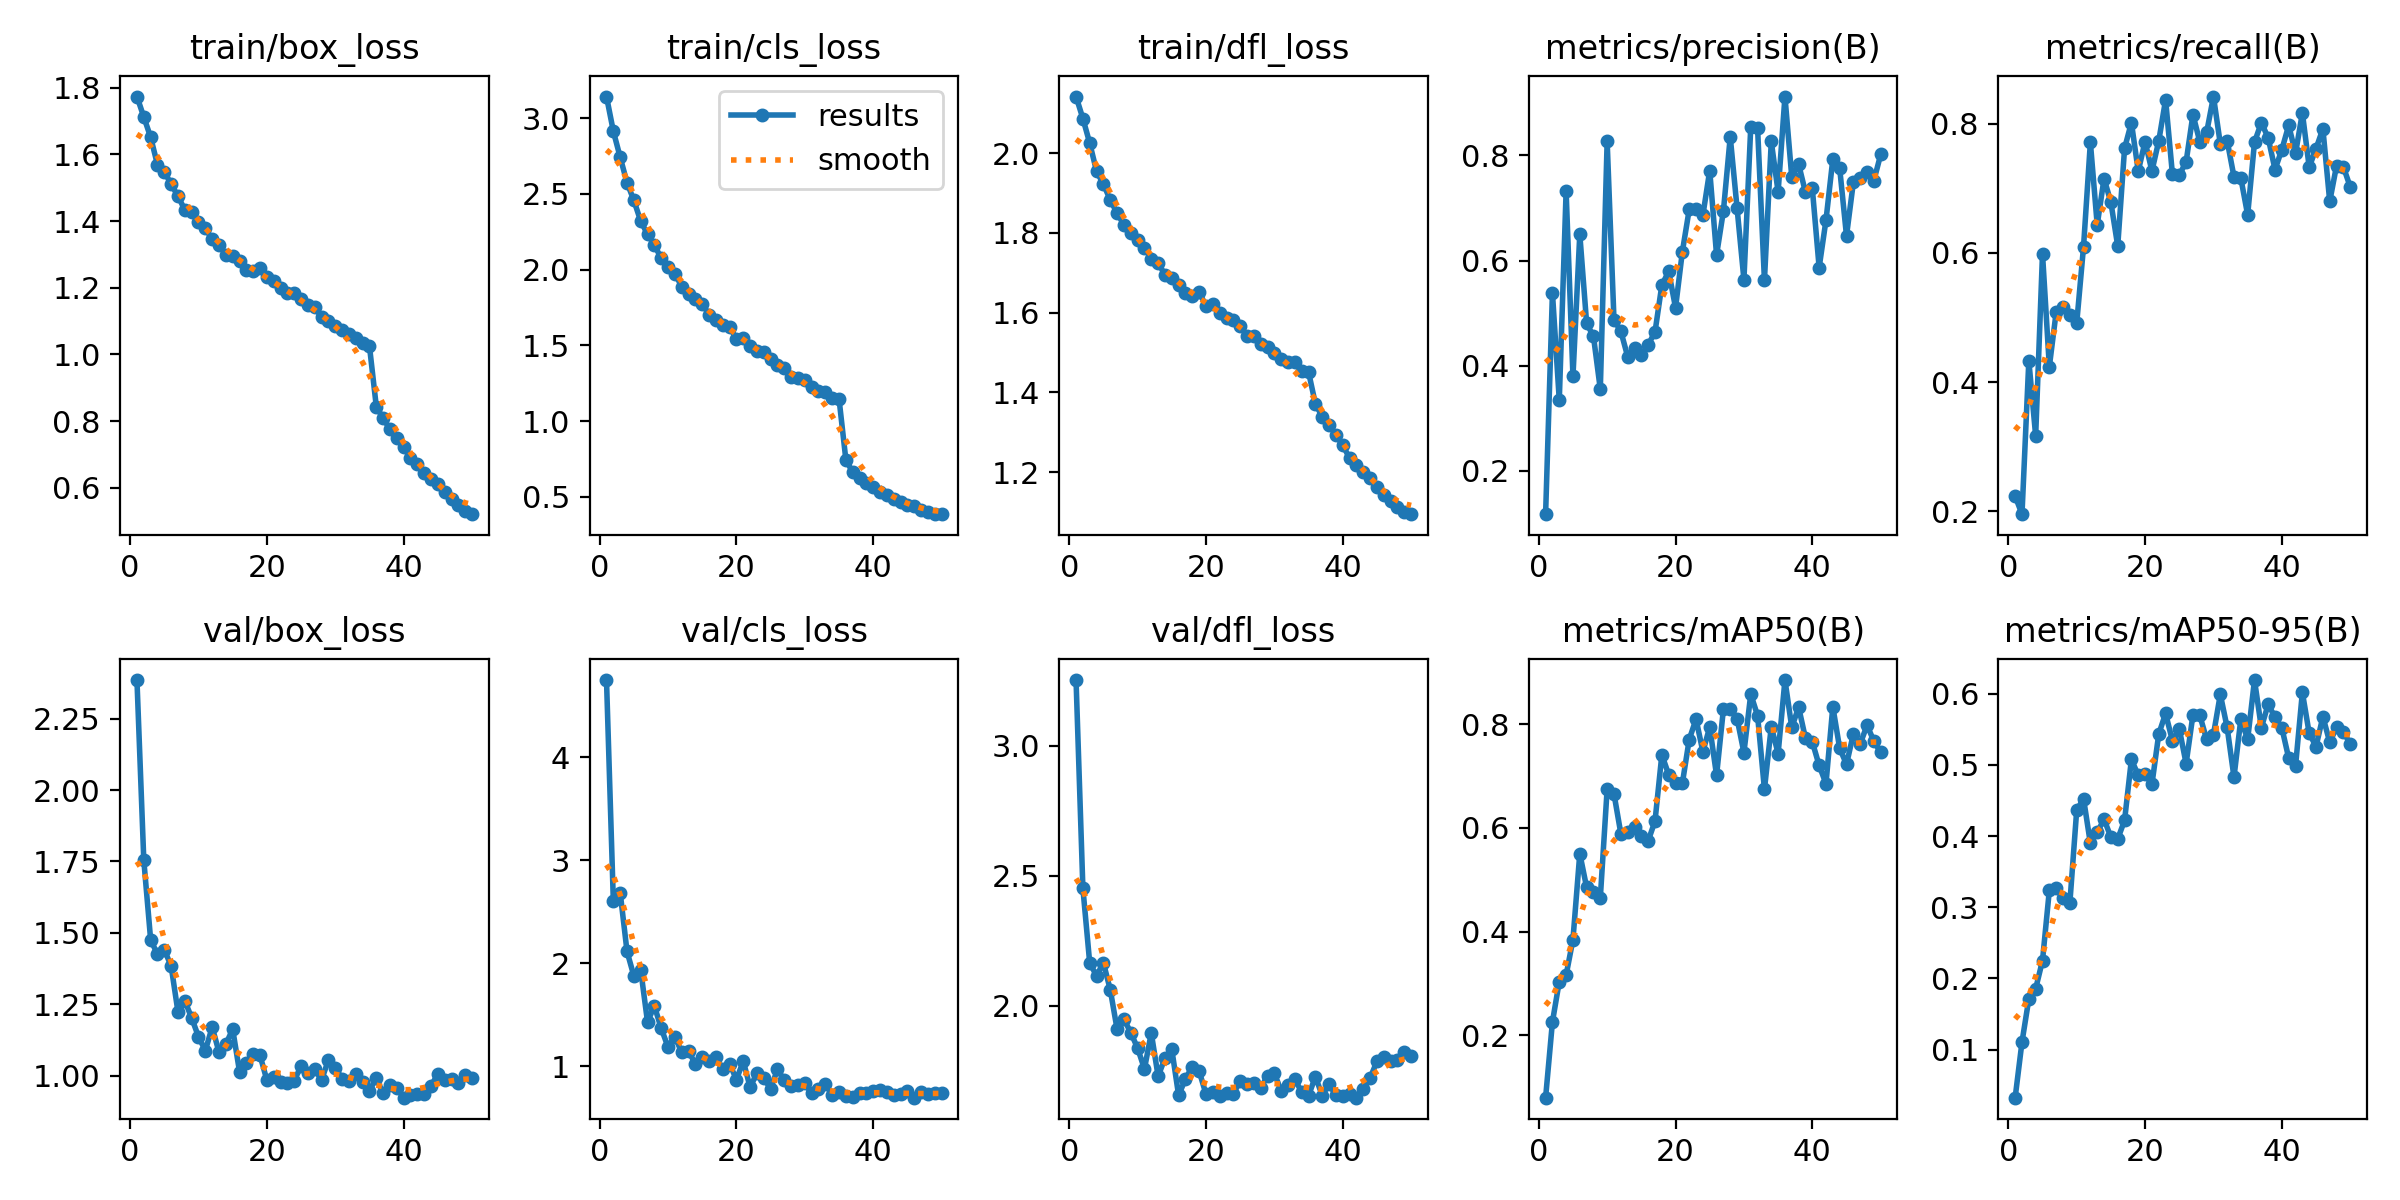

In [34]:
display(Image(filename='/content/runs/detect/train/confusion_matrix.png', width=800))

display(Image(filename='/content/runs/detect/train/BoxPR_curve.png', width=800))

display(Image(filename='/content/runs/detect/train/BoxF1_curve.png', width=800))

display(Image(filename='/content/runs/detect/train/results.png', width=900))

In [35]:
cls_names = model.model.names
df_metric = pd.DataFrame({
        'class'   : [cls_names[i] for i in range(len(cls_names))],
        'mAP@0.5' : results.box.maps
})
print('\nPer-class mAP@0.5')
print(df_metric.round(3))


Per-class mAP@0.5
            class  mAP@0.5
0      AyamGoreng    0.583
1          Capcay    0.831
2            Nasi    0.583
3      Sayurbayam    0.583
4   Sayurkangkung    0.695
5        Sayursop    0.583
6            Tahu    0.489
7      TelurDadar    0.754
8   TelurMataSapi    0.635
9      TelurRebus    0.531
10          Tempe    0.110
11    Tumisbuncis    0.621
12      food-z7P4    0.583


In [36]:
calorie_dict = {0:260, 1:67, 2:129, 3:36, 4:98, 5:22,
                6:80, 7:93, 8:110, 9:78, 10:225, 11:65, 12:0}


0: 640x640 1 TelurMataSapi, 37.0ms
Speed: 2.5ms preprocess, 37.0ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 TelurMataSapi, 37.0ms
Speed: 2.5ms preprocess, 37.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 TelurDadars, 36.9ms
Speed: 2.7ms preprocess, 36.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 TelurDadar, 30.7ms
Speed: 2.7ms preprocess, 30.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 TelurDadar, 25.8ms
Speed: 2.5ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


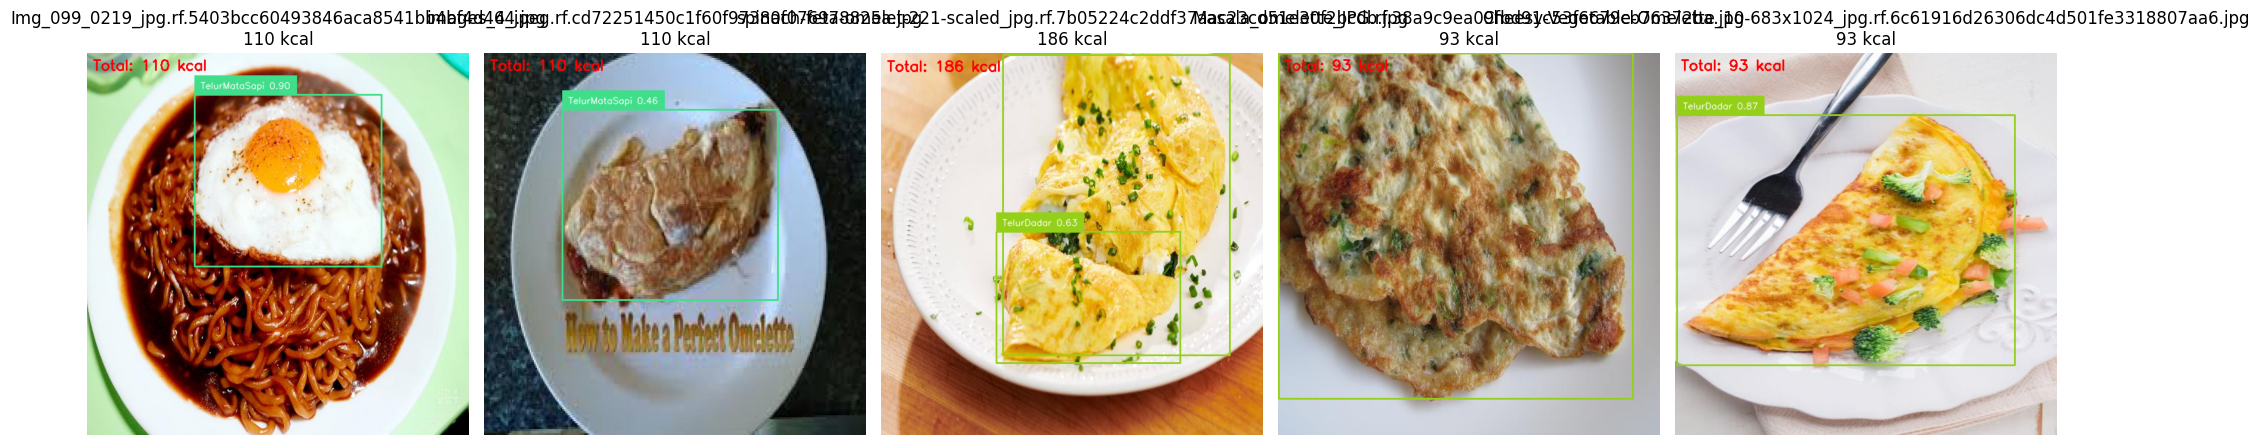

In [37]:
test_dir   = Path('/content/test/images')
save_vis   = Path('/content/test_vis')
save_vis.mkdir(exist_ok=True)


box_annotator   = sv.BoxAnnotator(thickness=2)
label_annotator = sv.LabelAnnotator(text_scale=0.5)

sample_imgs = list(test_dir.glob('*'))[:5]
fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for ax, img_path in zip(axes, sample_imgs):
    im0   = cv2.imread(str(img_path))
    preds = model(im0, conf=0.35, iou=0.45)[0]
    det   = sv.Detections.from_ultralytics(preds)

    cls_ids = det.class_id
    counts  = np.bincount(cls_ids, minlength=13)
    total_cal = sum(counts[i] * calorie_dict[i] for i in range(13))

    labels_box = [f"{model.names[cid]} {conf:.2f}"
                  for cid, conf in zip(det.class_id, det.confidence)]

    annotated = box_annotator.annotate(im0.copy(), det)
    annotated = label_annotator.annotate(annotated, det, labels_box)

    cv2.putText(annotated, f"Total: {total_cal} kcal",
                (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255), 2)

    ax.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    ax.set_title(f"{img_path.name}\n{total_cal} kcal")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [38]:
rows = []
for img_path in test_dir.glob('*'):
    im0   = cv2.imread(str(img_path))
    det   = sv.Detections.from_ultralytics(model(im0, conf=0.35)[0])
    counts = np.bincount(det.class_id, minlength=13)
    total  = sum(counts[i] * calorie_dict[i] for i in range(13))
    rows.append({'file': img_path.name, 'total_cal': total,
                 **{model.names[i]: counts[i] for i in range(13)}})
df_test = pd.DataFrame(rows)


0: 640x640 1 TelurMataSapi, 37.1ms
Speed: 2.9ms preprocess, 37.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 TelurMataSapi, 37.0ms
Speed: 2.8ms preprocess, 37.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 TelurDadars, 37.0ms
Speed: 2.2ms preprocess, 37.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 TelurDadar, 37.0ms
Speed: 2.2ms preprocess, 37.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 TelurDadar, 22.7ms
Speed: 2.1ms preprocess, 22.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 TelurDadar, 22.5ms
Speed: 2.1ms preprocess, 22.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Sayursop, 22.6ms
Speed: 2.5ms preprocess, 22.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 AyamGoreng, 1 TelurDadar, 2 Tempes, 22.3ms
Speed: 2.1ms preprocess, 22.